# optimizationBasedDispatchModel
- @param `df_locations` : pd.Dataframe型の地理情報データ
- @param `df_bikes` : pd.Dataframe型の自転車データ
- @return `optimizationBasedDispatchModel`

## solve()
- @param `df_requests` : pd.Dataframe型のユーザーリクエスト
- @return `results` : 自転車IDと割り当てられたユーザーのキューインデックスのタプル型の集合をlist型として結果を出力

In [ ]:
# ライブラリのインストール
!pip install ortools

# デバッグ用
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
import branca.colormap as cm
import cupy as cp
import folium
import ipdb #デバッグ用
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from ortools.linear_solver import pywraplp
from pandas import DataFrame
from scipy.interpolate import PchipInterpolator

In [ ]:
# データの準備

'''locationID検索用CSV'''
df_locations = pd.read_csv('/content/taxi_zone_lookup_with_coordinates.csv')

# 最後の2行を除外
df_locations = df_locations.iloc[:-2]

print(df_locations.head())
print(df_locations.tail())
df_locations.info()

   LocationID        Borough                     Zone service_zone   Latitude  \
0           1            EWR           Newark Airport          EWR  40.689531   
1           2         Queens              Jamaica Bay    Boro Zone  40.603994   
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone  40.865229   
3           4      Manhattan            Alphabet City  Yellow Zone  40.725102   
4           5  Staten Island            Arden Heights    Boro Zone  40.563700   

   Longitude  
0 -74.174462  
1 -73.835412  
2 -73.842739  
3 -73.979583  
4 -74.191603  
     LocationID    Borough                Zone service_zone   Latitude  \
258         259      Bronx  Woodlawn/Wakefield    Boro Zone  40.906716   
259         260     Queens            Woodside    Boro Zone  40.745380   
260         261  Manhattan  World Trade Center  Yellow Zone  40.711900   
261         262  Manhattan      Yorkville East  Yellow Zone  40.779282   
262         263  Manhattan      Yorkville West  Yello

In [ ]:
'''自転車の集合'''
# ランダムシードを設定して、ランダムに10個選択
np.random.seed(42)
random_sample = df_locations.sample(n=50, replace=True)

# Bike IDを設定
random_sample['Bike ID'] = range(50)

# 緯度と経度をホームポジションとカレントポジションに設定
random_sample['Home Position'] = list(zip(random_sample['Latitude'], random_sample['Longitude']))
random_sample['Current Location'] = random_sample['Home Position']

# 結果のデータフレームを整形
B = random_sample[['Bike ID', 'Home Position', 'Current Location']]
B.set_index("Bike ID", inplace=True)

# DODatetimeカラムを追加して初期値をNaTに設定
B['DODatetime'] = pd.NaT

# データの中身を確認
B

<ipython-input-5-580ff0a291be>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.688584, -74.019375)","(40.688584, -74.019375)",NaT
1,"(40.7355189, -73.9840794)","(40.7355189, -73.9840794)",NaT
2,"(40.65285365742539, -73.91998230758563)","(40.65285365742539, -73.91998230758563)",NaT
3,"(40.6778708, -73.9684725)","(40.6778708, -73.9684725)",NaT
4,"(40.61394235958525, -73.98139265868924)","(40.61394235958525, -73.98139265868924)",NaT
5,"(40.688584, -74.019375)","(40.688584, -74.019375)",NaT
6,"(40.7134361, -73.7670772)","(40.7134361, -73.7670772)",NaT
7,"(40.69562345, -73.79418630363637)","(40.69562345, -73.79418630363637)",NaT
8,"(40.702167688171, -74.01197755312633)","(40.702167688171, -74.01197755312633)",NaT


In [ ]:
'''ユーザーリクエストの集合'''

STARTING_DATE = '2023-01-01 0:00'
END_DATE = '2023-01-02 0:00'

# ParquetファイルのURL
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

# Parquetファイルを読み込む
df = pd.read_parquet(url)

# 指定されたカラムのみを含むデータフレームを取得
df_requests = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']]

# データのフィルタリング
# 2023年1月1日以前のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] >= STARTING_DATE]
# 2023年2月1日以降のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] < END_DATE]

# ピックアップタイムの昇順で並び替え
df_requests = df_requests.sort_values(by='tpep_pickup_datetime')

# インデックスをリセット
df_requests = df_requests.reset_index(drop=True)

# フィルタリングされたデータの先頭を表示
print(df_requests.head())

# データフレームの情報を表示
print(df_requests.info())

  tpep_pickup_datetime tpep_dropoff_datetime  PULocationID  DOLocationID
0  2023-01-01 00:00:00   2023-01-01 00:08:00            42            41
1  2023-01-01 00:00:05   2023-01-01 00:26:27           249           186
2  2023-01-01 00:00:06   2023-01-01 00:05:44           125            68
3  2023-01-01 00:00:08   2023-01-01 00:11:24            42           244
4  2023-01-01 00:00:09   2023-01-01 00:15:10            79           231
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76752 entries, 0 to 76751
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   76752 non-null  datetime64[us]
 1   tpep_dropoff_datetime  76752 non-null  datetime64[us]
 2   PULocationID           76752 non-null  int64         
 3   DOLocationID           76752 non-null  int64         
dtypes: datetime64[us](2), int64(2)
memory usage: 2.3 MB
None


In [ ]:
from math import dist
# optimizationBasedDispatchModelクラスを定義
class optimizationBasedDispatchModel():
  def __init__(self, df_locations, df_bikes):
    self.df_locations = df_locations
    self.df_bikes = df_bikes


  '''LocationIDから経度と緯度をタプルで返す関数'''
  def _get_coordinates_by_location_id(self, location_id):
    row = self.df_locations[self.df_locations['LocationID'] == location_id]
    if not row.empty:
        latitude = row.iloc[0]['Latitude']
        longitude = row.iloc[0]['Longitude']
        # 緯度と経度が有効な数値であるかどうかを確認する
        if pd.notna(latitude) and pd.notna(longitude):
            return (latitude, longitude)
        else:
            return None
    else:
        # ipdb.set_trace()  # ブレークポイントを設定
        return None


  '''2点間のハヴァージン距離を算出する関数(GPU対応)'''
  def _haversine_distance(
      self,
      lat1: float,
      lon1: float,
      lat2: float,
      lon2: float,
  ) -> float:
      R = 6371000  # 地球の平均半径 (m)
      phi1 = cp.radians(lat1)
      phi2 = cp.radians(lat2)
      delta_phi = cp.radians(lat2 - lat1)
      delta_lambda = cp.radians(lon2 - lon1)

      a = cp.sin(delta_phi / 2)**2 + cp.cos(phi1) * cp.cos(phi2) * cp.sin(delta_lambda / 2)**2
      c = 2 * cp.arctan2(cp.sqrt(a), cp.sqrt(1 - a))

      return R * c  # 距離 (m)


  '''ユーザーリクエストJに対して移動後の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_after_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 自転車のホームポジションを取得
      home_positions = cp.array(self.df_bikes['Home Position'].to_list())

      # リクエストの目的地を取得
      # print(df_requests['DOLocationID'])
      # print(self._get_coordinates_by_location_id)
      request_destinations = cp.array(df_requests['DOLocationID'].apply(self._get_coordinates_by_location_id).to_list())
      # 変更箇所：リスト内包表記を使用して2D配列を作成
      # request_destinations = cp.array([[coord[0], coord[1]] for coord in df_requests['DOLocationID'].apply(self._get_coordinates_by_location_id).to_list()])

      # 移動後の距離行列 d を作成 (d[b, j] が利用者 j が移動した後の自転車 b とその定位置までの距離)
      # 距離行列を初期化
      after_trip_distances = cp.zeros((num_bikes, num_requests))

      # 距離を計算
      for b in range(num_bikes):
          home_lat, home_lon = home_positions[b]
          dest_lats = request_destinations[:, 0]
          dest_lons = request_destinations[:, 1]
          distances = self._haversine_distance(home_lat, home_lon, dest_lats, dest_lons)
          after_trip_distances[b, :] = distances

      # print('-----after_trip_distances-----')
      # print(after_trip_distances)
      return after_trip_distances.get() # cupy配列をnumpy配列に変換して返す


  '''ユーザーリクエストJに対して移動前の自転車Bの位置関係を表す距離行列を返す関数'''
  def _generate_before_trip_distances(
      self,
      df_requests: DataFrame,
  ) -> np.ndarray:

      # 自転車とリクエストの数
      num_bikes = len(self.df_bikes)
      num_requests = len(df_requests)

      # 自転車の現在位置を取得
      current_locations = cp.array(self.df_bikes['Current Location'].to_list())

      # リクエストのピックアップ地点を取得
      request_pickups = cp.array(df_requests['PULocationID'].apply(self._get_coordinates_by_location_id).to_list())

      # 移動前の距離行列 d を作成 (d[b, j] が利用者 j のリクエスト地点と自転車 b の現在地との距離)
      # 距離行列を初期化
      before_trip_distances = cp.zeros((num_bikes, num_requests))

      # 距離を計算
      for b in range(num_bikes):
          current_lat, current_lon = current_locations[b]
          pickup_lats = request_pickups[:, 0]
          pickup_lons = request_pickups[:, 1]
          distances = self._haversine_distance(current_lat, current_lon, pickup_lats, pickup_lons)
          before_trip_distances[b, :] = distances

      # print('-----before_trip_distances-----')
      # print(before_trip_distances)
      return before_trip_distances.get() # cupy配列をnumpy配列に変換して返す


  '''利用可能な自転車の集合を返す関数'''
  def _get_available_bikes(
      self,
      current_time: datetime = None
  ) -> np.ndarray:
      # current_timeがNoneの場合、現在時刻を取得
      # 本番運用時はcurrent_timeを利用しない
      if current_time is None:
          current_time = datetime.now()

      # 利用可能な自転車を1、不可能な自転車を0とする行列を作成
      # available_bikes = (B['DODatetime'].isna() | (B['DODatetime'] < current_time)).astype(int)
      available_bikes = (self.df_bikes['DODatetime'].isna() | (self.df_bikes['DODatetime'] < current_time)).astype(int)
      # print('-----available_bikes.values-----')
      # print(available_bikes.values)
      return available_bikes.values


  '''割り当て成功後の自転車ステータスの更新'''
  def _update_bike_status(
      self,
      bike_assignment,
      df_requests
  ):
      for b, j in bike_assignment:
          # jのtpep_dropoff_datetimeを取得するし自転車ステータス更新する
          # df_requestsのインデックスjに対応する行を取得
          request_row = df_requests.iloc[j]
          self.df_bikes.at[b, 'DODatetime'] = request_row['tpep_dropoff_datetime']
          # jのDOLocationIDを取得して自転車のCurrent Locationを更新する
          self.df_bikes.at[b, 'Current Location'] = self._get_coordinates_by_location_id(request_row['DOLocationID'])


  '''結果出力用メソッド'''
  def _print_results(self, result_dict):
      # 辞書型のそれぞれのデータに対して"key: value"形式で出力する
      for key, value in result_dict.items():
          print(f"{key}: {value}")
      # print("-------------------------------------------------------")

  '''最適化メイン処理'''
  def solve(self, df_requests):
    # 263以上のPULocationID/DOLocationIDを持つリクエストを除外
    df_requests = df_requests[df_requests['PULocationID'] < 263]
    df_requests = df_requests[df_requests['DOLocationID'] < 263]

    # ipdb.set_trace()  # ブレークポイントを設定
    # ユーザーリクエストJに対して移動された自転車Bにおける、自転車の定位置との距離行列

    distances = self._generate_after_trip_distances(df_requests)
    # ユーザーリクエストJに対してマッチングする前の自転車との距離行列
    initial_distances = self._generate_before_trip_distances(df_requests)

    # 利用可能な自転車を取得する
    # df_requestsの最終行のtpep_pickup_datetimeカラムの値を取得する
    current_time = df_requests.iloc[-1]['tpep_pickup_datetime']
    # print('-----current_time-----')
    # print(current_time)
    available_bikes = self._get_available_bikes(current_time)

    # 問題の正規化
    average = distances.mean()
    std = distances.std()
    distances: np.ndarray = (distances - average) / std


    # OR-Toolsのソルバーを作成
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # 変数の定義
    x = []
    for b in range(self.df_bikes.shape[0]):
        x.append([])
        for j in range(df_requests.shape[0]):
            x[b].append(solver.BoolVar(f'x[{b},{j}]'))

    alpha = 1.0

    # 目的関数の定義
    # 第一項: ユーザーの移動後の自転車の現在地と定位置との距離を短くする
    distance_objective = solver.Sum(distances[b][j] * x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))
    # 第二項: より多くのユーザーに自転車を割り当てる
    sum_x = solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0]) for j in range(df_requests.shape[0]))

    objective = distance_objective - alpha * sum_x
    solver.Minimize(objective)

    # 制約条件の定義

    # 各ユーザーは1台の自転車にしか割り当てられない
    for b in range(self.df_bikes.shape[0]):
        solver.Add(solver.Sum(x[b][j] for j in range(df_requests.shape[0])) <= 1)

    # 各自転車は１人のユーザーにしか割り当てられない
    for j in range(df_requests.shape[0]):
        solver.Add(solver.Sum(x[b][j] for b in range(self.df_bikes.shape[0])) <= 1)

    # 徒歩30分で移動できる距離
    R = 2500
    # 半径r内に存在する自転車しかユーザーに割り当てない制約
    for b in range(self.df_bikes.shape[0]):
        for j in range(df_requests.shape[0]):
            if initial_distances[b][j] > R:
                solver.Add(x[b][j] == 0)

    # 他ユーザーに割り当てられていない利用可能な自転車のみを割り当てる
    for b in range(available_bikes.shape[0]):
        if available_bikes[b] == 0:
            for j in range(df_requests.shape[0]):
                solver.Add(x[b][j] == 0)

    # ipdb.set_trace()  # ブレークポイントを設定
    # ソルバーを実行
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('解が見つかりました:')
        bike_assignment = []
        for b in range(self.df_bikes.shape[0]):
            for j in range(df_requests.shape[0]):
                if x[b][j].solution_value() == 1:
                    bike_assignment.append((b, j))
                    # print(f"利用者 {j}: 自転車 {b}")
        self._update_bike_status(bike_assignment, df_requests)
        # _print_results()に結果を渡して出力する
        result_dict = {
            "Distance objective": distance_objective.solution_value(),
            "Sum of assignments": sum_x.solution_value(),
            "Objective value": objective.solution_value(),
            "bike_assignment": bike_assignment,
        }
        self._print_results(result_dict) #←モデル検証・デバッグ用
        return bike_assignment #←モデル検証・デバッグ時はコメントアウトする。実際にはこれを返す。
    else:
        raise RuntimeError("No feasible solution was found.")


# 動作確認

In [ ]:
# optimizationBasedDispatchModelの初期化・インスタンス作成
optimizationBasedDispatchModel = optimizationBasedDispatchModel(df_locations, B)

In [ ]:
def calculate_total_distance(df):
    """
    データフレームからホームポジションとカレントポジションのノルムの総和を計算する関数。

    :param df: ホームポジションとカレントポジションを含むデータフレーム
    :return: 距離の総和
    """
    total_distance = 0
    for _, row in df.iterrows():
        home_pos = np.array(row['Home Position'])
        current_loc = np.array(row['Current Location'])
        distance = np.linalg.norm(home_pos - current_loc)
        total_distance += distance
    return total_distance

In [ ]:
# モデリングするためにユーザーリクエストデータを整形する

# tpep_pickup_datetimeをdatetime型に変換
df_requests['tpep_pickup_datetime'] = pd.to_datetime(df_requests['tpep_pickup_datetime'])
df_requests['tpep_dropoff_datetime'] = pd.to_datetime(df_requests['tpep_dropoff_datetime'])

# リクエストデータを一分ごとに分割
start_time = df_requests['tpep_pickup_datetime'].min()
end_time = df_requests['tpep_pickup_datetime'].max()
print(f"リクエストの開始時間：{start_time}")
print(f"リクエストの終了時間：{end_time}")
print(f"リバランスコスト初期値：{calculate_total_distance(B)}")

# マッチングプロセスのログデータ収集用時系列データ
time_series_log_data = []

# データを1分ごとに処理
current_time = start_time
while current_time < end_time:
    print(f"Time: {current_time}")
    next_time = current_time + pd.Timedelta(minutes=5)
    # 現在の1分間のリクエストを抽出
    J = df_requests[(df_requests['tpep_pickup_datetime'] >= current_time) & (df_requests['tpep_pickup_datetime'] < next_time)]
    # print(J)
    if not J.empty:
        # solve()を実行
        # print(J)
        # if current_time == datetime.strptime('2023-01-01 00:03:00', '%Y-%m-%d %H:%M:%S'):
        #     # テスト用に3分間で停止する。
        #     break

        # 自転車占有率を計算する
        available_bikes = optimizationBasedDispatchModel._get_available_bikes(current_time)
        bikes_occupied_rate = 1 - available_bikes.sum() / len(available_bikes)
        print(f"Bikes Occupied Rate: {bikes_occupied_rate}")

        # PULocationIDまたはDOLocationIDが262より大きい場合は不正なリクエストとしてエラー文を出力して次の処理へスキップする
        if J['PULocationID'].values[0] > 262 or J['DOLocationID'].values[0] > 262:
            print("Invalid request. PULocationID or DOLocationID is greater than 262.")
            print("-------------------------------------------------------")
            # 次の1分へ移動
            current_time = next_time
            continue

        #本番用
        try:
            bike_assignment = optimizationBasedDispatchModel.solve(J)
            # print(f"Time: {current_time}, Assignments: {bike_assignment}")
        except RuntimeError:
            bike_assignment = []
            print("No feasible solution was found.")
            print("-------------------------------------------------------")

        # テスト用
        # print(f"Time: {current_time}")
        # optimizationBasedDispatchModel.solve(J)

        # マッチング成功率を計算する
        matching_success_rate = len(bike_assignment) / len(J)
        print(f"Matching Success Rate: {matching_success_rate}")

        # 自転車の再配置コストを計算する
        rebalance_cost = calculate_total_distance(B)
        print(f"Rebalance Cost: {rebalance_cost}")
        print("-------------------------------------------------------")

        # ログ出力
        time_series_log_data.append({
            'time': current_time,
            'matching_success_rate': matching_success_rate,
            'bikes_occupied_rate': bikes_occupied_rate,
            'rebalance_cost': rebalance_cost
        })

    # 次の1分へ移動
    current_time = next_time


リクエストの開始時間：2023-01-01 00:00:00
リクエストの終了時間：2023-01-01 23:59:57
リバランスコスト初期値：0.0
Time: 2023-01-01 00:00:00
Bikes Occupied Rate: 0.0
解が見つかりました:
Distance objective: -19.480307919799237
Sum of assignments: 17.0
Objective value: -36.48030791979924
bike_assignment: [(0, 109), (1, 9), (3, 62), (5, 84), (6, 97), (8, 22), (9, 24), (10, 0), (14, 68), (15, 93), (18, 6), (21, 71), (27, 16), (36, 15), (40, 94), (48, 89), (49, 88)]
Matching Success Rate: 0.1297709923664122
Rebalance Cost: 0.9768770850477569
-------------------------------------------------------
Time: 2023-01-01 00:05:00
Bikes Occupied Rate: 0.30000000000000004
解が見つかりました:
Distance objective: -19.997922346611723
Sum of assignments: 11.0
Objective value: -30.997922346611723
bike_assignment: [(1, 10), (2, 17), (9, 164), (10, 70), (14, 79), (15, 103), (18, 215), (21, 80), (40, 39), (48, 6), (49, 41)]
Matching Success Rate: 0.03323262839879154
Rebalance Cost: 0.6953359608789423
-------------------------------------------------------
Time: 

In [ ]:
# 自転車のステータスを確認
B

,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.688584, -74.019375)","(40.6784201, -73.9948021)",2023-01-01 21:47:16
1,"(40.7355189, -73.9840794)","(40.7355189, -73.9840794)",2023-01-02 05:53:37
2,"(40.65285365742539, -73.91998230758563)","(40.605516, -73.93487)",2023-01-01 18:51:20
3,"(40.6778708, -73.9684725)","(40.659097, -73.95468)",2023-01-01 23:29:33
4,"(40.61394235958525, -73.98139265868924)","(40.6462149, -73.970694)",2023-01-01 23:17:20
5,"(40.688584, -74.019375)","(40.68562615, -73.98417065807277)",2023-01-01 22:52:43
6,"(40.7134361, -73.7670772)","(40.6701035, -73.8190231)",2023-01-01 17:13:01
7,"(40.69562345, -73.79418630363637)","(40.7029134, -73.8006429)",2023-01-01 23:57:12
8,"(40.702167688171, -74.01197755312633)","(40.68562615, -73.98417065807277)",2023-01-01 23:57:59


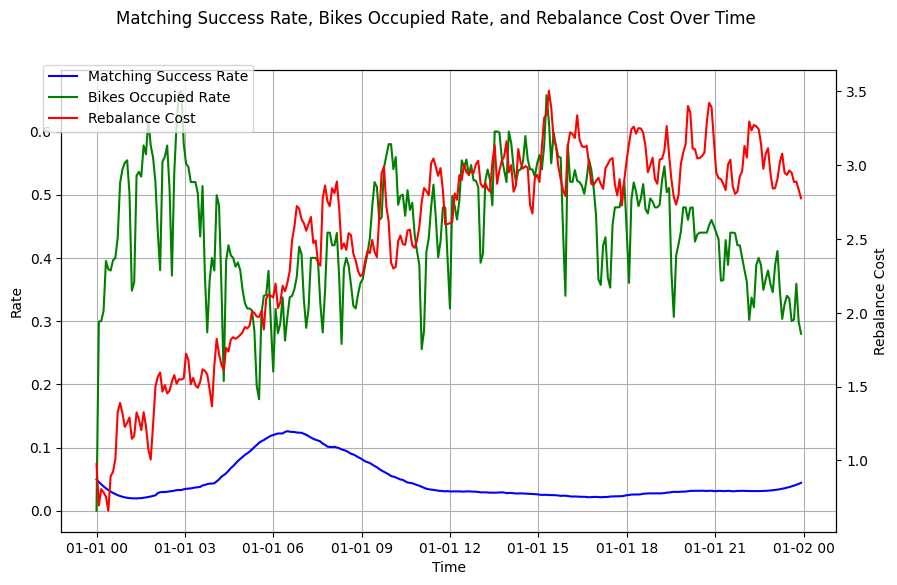

In [ ]:
# 自転車の割り当て成功率と占有率とリバランスコストの関係をグラフ化する

from scipy.signal import savgol_filter

# ログデータをデータフレームにコンバートする
df_time_series = pd.DataFrame(time_series_log_data)

# 時間データを数値に変換
time = df_time_series['time'].astype('int64') / 1e9  # 秒に変換

# 補間のための新しい時間データを作成
time_new = np.linspace(time.min(), time.max(), 300)

# PCHIP補間
pchip_matching_success_rate = PchipInterpolator(time, df_time_series['matching_success_rate'])
matching_success_rate_smooth = pchip_matching_success_rate(time_new)
# 分かりにくいため、ローパスフィルタを使用して滑らかにする
matching_success_rate_smooth = savgol_filter(matching_success_rate_smooth, window_length=51, polyorder=3)

pchip_bikes_occupied_rate = PchipInterpolator(time, df_time_series['bikes_occupied_rate'])
bikes_occupied_rate_smooth = pchip_bikes_occupied_rate(time_new)

pchip_rebalance_cost = PchipInterpolator(time, df_time_series['rebalance_cost'])
rebalance_cost_smooth = pchip_rebalance_cost(time_new)

# プロット
fig, ax1 = plt.subplots(figsize=(10, 6))

# 新しい時間データをDateTimeに変換してプロット
time_new_datetime = pd.to_datetime(time_new * 1e9)

# 左側のY軸に割り当て成功率と自転車の占有率をプロット
ax1.plot(time_new_datetime, matching_success_rate_smooth, label='Matching Success Rate', color='b')
ax1.plot(time_new_datetime, bikes_occupied_rate_smooth, label='Bikes Occupied Rate', color='g')
ax1.set_xlabel('Time')
ax1.set_ylabel('Rate', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# 右側のY軸にリバランスコストをプロット
ax2 = ax1.twinx()
ax2.plot(time_new_datetime, rebalance_cost_smooth, label='Rebalance Cost', color='r')
ax2.set_ylabel('Rebalance Cost', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# グラフのタイトルと凡例の設定
fig.suptitle('Matching Success Rate, Bikes Occupied Rate, and Rebalance Cost Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

ax1.grid(True)

plt.show()

# 最終自転車分布

In [ ]:
'''ユーザーの位置と自転車の位置をプロットする関数'''
def plot_users_and_bikes(
    user_locations: np.ndarray,
    bike_locations: np.ndarray,
    latitude_range: tuple[float, float],  # 描画範囲 (緯度)
    longitude_range: tuple[float, float],  # 描画範囲 (経度)
):
    m = folium.Map(
        [sum(latitude_range) / 2, sum(longitude_range) / 2],
        tiles="OpenStreetMap",
        zoom_start=11,
    )

    for latitude, longitude in user_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="user", prefix="fa", color="orange"),
        ).add_to(m)

    for latitude, longitude in bike_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="bicycle", prefix="fa", color="green"),
        ).add_to(m)

    return m

In [ ]:
# latitudeカラムとlongitudeカラムの最大値と最小値を取得
latitude_max = df_locations['Latitude'].max()
latitude_min = df_locations['Latitude'].min()
longitude_max = df_locations['Longitude'].max()
longitude_min = df_locations['Longitude'].min()

# 結果を表示
print(f"Latitude: max = {latitude_max}, min = {latitude_min}")
print(f"Longitude: max = {longitude_max}, min = {longitude_min}")

Latitude: max = 40.908178, min = 40.52825085411132
Longitude: max = -73.7115199, min = -74.23462644152289


In [ ]:
# NYC
latitude_range = (latitude_min - 0.1, latitude_max + 0.1)
longitude_range = (longitude_min - 0.1, longitude_max + 0.1)
print(latitude_range)
print(longitude_range)

current_locations = B['Current Location'].values
print(type(current_locations))
print(current_locations)

(40.42825085411132, 41.008178)
(-74.33462644152289, -73.6115199)
<class 'numpy.ndarray'>
[(40.6784201, -73.9948021) (40.7355189, -73.9840794)
 (40.605516, -73.93487) (40.659097, -73.95468) (40.6462149, -73.970694)
 (40.68562615, -73.98417065807277) (40.6701035, -73.8190231)
 (40.7029134, -73.8006429) (40.68562615, -73.98417065807277)
 (40.750201, -73.993104) (40.7985612, -73.9530142)
 (40.6701035, -73.8190231) (40.695728917332445, -73.91714541151819)
 (40.823144, -73.81076) (40.768713, -73.7470765) (40.7650637, -73.9853191)
 (40.57580705, -73.99217527476975) (40.796708, -73.779396)
 (40.78366657018949, -73.94764843602209) (40.665306, -73.9124755)
 (40.8884329, -73.8281895) (40.76, -73.8130556)
 (40.64664294592187, -74.02068104961789)
 (40.67553311670336, -73.94403751076791) (40.7876014, -73.8459682)
 (40.8381903, -73.8874364) (40.5777777, -73.97493451658843)
 (40.8453781, -73.8909693) (40.7267692, -73.7415208)
 (40.616287905028585, -74.00096205376043) (40.6751032, -74.0095841)
 (40.815

In [ ]:
plot_users_and_bikes([], current_locations, latitude_range, longitude_range)

In [ ]:
# ログのCSV出力
from google.colab import files
filename =  "result_by_optimizationModelWithCupy_50_5m.csv"
df_time_series.to_csv(filename, encoding = 'utf-8-sig')
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 再配置コストについての実態調査

### 再配置コスト算出方法
2点の座標を

home_position = ($x_1$, $y_1$), current_location = ($x_2$, $y_2$)

とする

In [ ]:
def calculate_actual_total_distance(df):
    """
    DataFrameの各行に対して、ホームポジションと現在位置（緯度・経度：度単位）の差分を
    実際の距離（メートル）に変換し、その総和を計算する関数。

    変換方法:
    - 緯度方向: 1度 ≒ 111320 m
    - 経度方向: 1度 ≒ 111320 * cos(平均緯度) m （平均緯度はラジアンに変換）

    :param df: 'Home Position'と'Current Location'の列を持つDataFrame
               各セルは (latitude, longitude) のタプル（度単位）
    :return: 総距離（メートル単位）
    """
    total_distance = 0
    for _, row in df.iterrows():
        # 座標を取得（度単位）
        home_lat, home_lon = row['Home Position']
        current_lat, current_lon = row['Current Location']

        # 座標の差（度単位）
        delta_lat = home_lat - current_lat
        delta_lon = home_lon - current_lon

        # 緯度方向の距離変換（メートル）
        lat_distance = delta_lat * 111320

        # 経度方向は、平均緯度に依存するのでまず平均緯度を計算（度単位）
        mean_lat = (home_lat + current_lat) / 2
        # 平均緯度をラジアンに変換してから、経度方向の距離変換
        lon_distance = delta_lon * 111320 * np.cos(np.deg2rad(mean_lat))

        # ユークリッド距離（メートル単位）
        distance = np.sqrt(lat_distance**2 + lon_distance**2)
        total_distance += distance

    return total_distance

In [ ]:
print("10台あたりの再配置移動に要する延べ距離：", calculate_actual_total_distance(B) / 5, "(m)")

10台あたりの再配置移動に要する延べ距離： 54198.56602730639 (m)
